# Inferance on [Breast Ultrasound Images Dataset](https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset) dataset using Fine-tuned SAM.
1. Train the model using `train.py` or `train_no_npz.py` and save the checkpoints.

In [51]:
from glob import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

## Prepare the dataset

In [52]:
from utils.dataset import MedSamDataset

In [53]:
# dataset directory
dataset_dir = "./data/Tmp/"

!ls $dataset_dir

44685902-a2ada121-02735bc5-bf1bf167-adfd2ae5-img.jpg
44685902-a2ada121-02735bc5-bf1bf167-adfd2ae5-mask.jpg
803fcbd8-2e38a5c7-cca96a50-ce5660cb-83ecc3a1-img.jpg
803fcbd8-2e38a5c7-cca96a50-ce5660cb-83ecc3a1-mask.jpg


Prepare the `dataframe` with columns for the `images` and `masks`

In [58]:
import re

all_images = glob(dataset_dir+"/*jpg")

mask_pattern = re.compile(r'(.*)-mask.jpg')
image_pattern = re.compile(r'(.*)-img.jpg')

images = sorted([image for image in all_images if image_pattern.match(image)])
masks = sorted([mask for mask in all_images if mask_pattern.match(mask)])

df = pd.DataFrame(
    {
    "image":images,
    "mask":masks
    }
    )
df.head()

,image,mask
0,./data/Tmp/44685902-a2ada121-02735bc5-bf1bf167...,./data/Tmp/44685902-a2ada121-02735bc5-bf1bf167...
1,./data/Tmp/803fcbd8-2e38a5c7-cca96a50-ce5660cb...,./data/Tmp/803fcbd8-2e38a5c7-cca96a50-ce5660cb...


Prepare the pytorch `Dataset` object

In [59]:
# `image_dir` and `mask_dir` will be omitted since the column hold the relative
# path of the images and masks
ds = MedSamDataset(df,image_col="image",mask_col="mask")

Prepare the pytorch `DataLoader` object

In [60]:
from torch.utils.data import DataLoader

batch_size = 4

dataloader = DataLoader(ds,batch_size=batch_size,shuffle=True)

display sample image and mask pairs in a given batch

In [61]:
images,masks,bboxes = next(iter(dataloader))

images.shape, masks.shape, bboxes.shape,

(torch.Size([2, 3, 256, 256]),
 torch.Size([2, 1, 256, 256]),
 torch.Size([2, 4]))

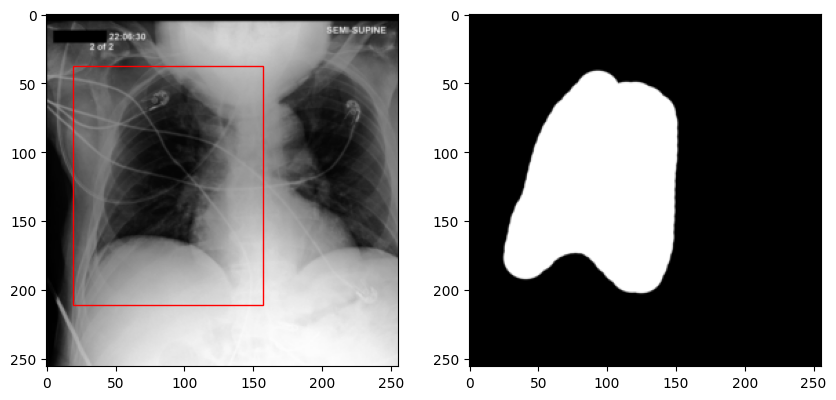

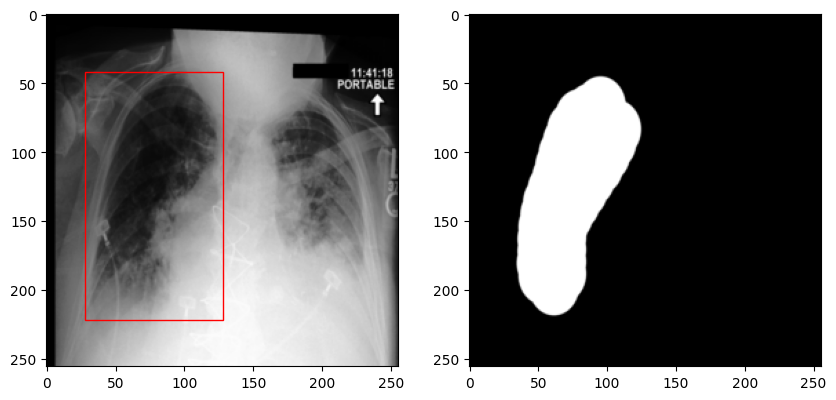

In [62]:
for i in range(images.shape[0]):
  image = images[i]
  mask = masks[i]
  bbox = bboxes[i]

  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0],bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
  plt.imshow(np.uint8(image.permute(1,2,0).numpy()),cmap="gray")
  plt.gca().add_patch(rect)

  plt.subplot(1,2,2)
  plt.imshow(mask.permute(1,2,0),cmap="gray")

  plt.show()

### Inferance and Evaluation on finetuned SAM

In [63]:
import torch
from torch.utils.data import DataLoader
from segment_anything import sam_model_registry,SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

Load checkpoints

In [64]:
sam_checkpoint_dir = './work_dir/SAM/sam_vit_b_01ec64.pth'
med_sam_checkpoint_dir = "./work_dir/MedSAM/medsam_20230423_vit_b_0.0.1.pth"
model_type = 'vit_b'
device = 'cuda:0'

In [65]:
# initialize sam model
sam_model = sam_model_registry[model_type](checkpoint=med_sam_checkpoint_dir).to(device)

In [66]:
def dice_coefficient(preds, targets):
  smooth = 1.0
  assert preds.size() == targets.size()

  iflat = preds.contiguous().view(-1)
  tflat = targets.contiguous().view(-1)
  intersection = (iflat * tflat).sum()
  dice = (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)
  return dice

In [67]:
@torch.inference_mode()
def medsam_prediction(image,bbox):
    sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
    #trans_image = image.unsqueeze(0).to(device)
    trans_image = sam_trans.apply_image_torch(image)
    box = sam_trans.apply_boxes(bbox, (256, 256))
    box_tensor = torch.as_tensor(box, dtype=torch.float, device=device)
    # Get predictioin mask
    
    image_embeddings = sam_model.image_encoder(trans_image)  # (B,256,64,64)

    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_tensor, #box_tensor,
        masks=None,
    )
    mask_predictions, _ = sam_model.mask_decoder(
        image_embeddings=image_embeddings.to(device),  # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )
    mask_predictions = torch.sigmoid(mask_predictions)

    return (mask_predictions > 0.5).int()

In [68]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [69]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2)) 

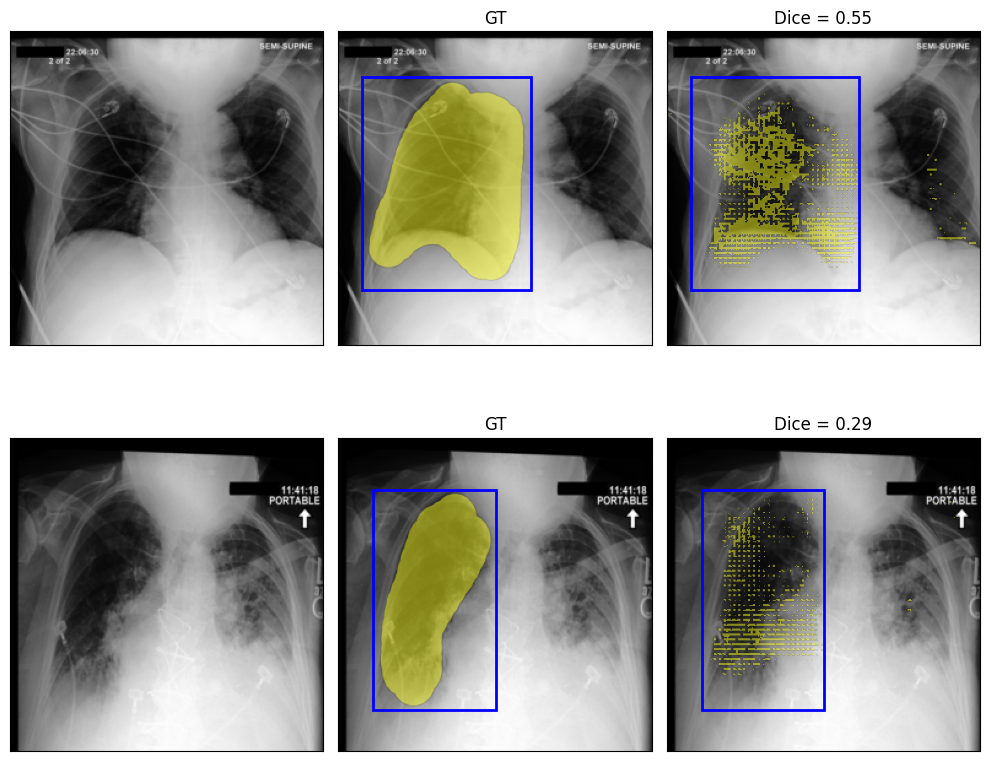

In [71]:
images = images.to(device)
masks = masks.to(device)
mask_prediction = medsam_prediction(images,bboxes)


fig,axs = plt.subplots(images.shape[0],3,figsize=(10,10),subplot_kw={"xticks":[],"yticks":[]})
for i in range(images.shape[0]):

  image = np.uint8(images[i].permute(1,2,0).cpu().numpy())
  mask = masks[i]
  pred_mask = mask_prediction[i]

  dice = dice_coefficient(pred_mask,mask)

  mask = mask.cpu().numpy()
  pred_mask = pred_mask.cpu().numpy()

  axs[i][0].imshow(image,cmap="gray")

  axs[i][1].imshow(image,cmap="gray")
  show_mask(mask,axs[i][1])
  show_box(bboxes[i],axs[i][1])
  axs[i][1].set_title(f"GT")

  axs[i][2].imshow(image,cmap="gray")
  show_mask(pred_mask,axs[i][2])
  show_box(bboxes[i],axs[i][2])
  
  axs[i][2].set_title(f"Dice = {dice.item():.2f}")

  plt.tight_layout()